In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig, TaskType

In [2]:
df = pd.read_csv("./low_confidence_samples/big_data.csv")
df

,text,label,preprocess_text
0,One of the other reviewers has mentioned that ...,1,reviewer mention watch 1 oz episode hook right...
1,I sure would like to see a resurrection of a u...,1,sure like resurrection date seahunt series tec...
2,I saw this movie when I was about 12 when it c...,0,see movie 12 come recall scary scene big bird ...
3,This a fantastic movie of three prisoners who ...,1,fantastic movie prisoner famous actor george c...
4,"""Ardh Satya"" is one of the finest film ever ma...",1,ardh satya fine film indian cinema direct grea...
...,...,...,...
51031,A man came to the house to estimate. He gave m...,0,man come house estimate give card person say r...
51032,When Corey sent the email about tickets being ...,1,corey send email ticket available jump opportu...
51033,I'm shocked everyone time I go to a Bouchon Ba...,0,shocked time bouchon bakery outside yountville...
51034,Looks like all of the good reviews have gone t...,0,look like good review go head place jason ry...


In [16]:
df['label'].unique()
df['label'].value_counts()

label
1    25679
0    25410
Name: count, dtype: int64

In [17]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True)

# Ensure text data is a list of strings and drop missing values
df_train['text'] = df_train['preprocess_text'].astype(str)
df_test['text'] = df_test['preprocess_text'].astype(str)

# Ensure text is lowercase
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

In [18]:
df_train

,text,label,preprocess_text
40326,place yummy taste burger try spot town 5 guy f...,1,place yummy taste burger try spot town 5 guy f...
49451,good caf\u00e9 neighborhood know way far defin...,1,good caf\u00e9 neighborhood know way far defin...
38042,love place small big price serving reduce da...,0,love place small big price serving reduce da...
28778,read fellow yelper seth y review immediately o...,1,read fellow yelper seth y review immediately o...
29574,way sub 5 buck choice kind meat topping plus...,1,way sub 5 buck choice kind meat topping plus...
...,...,...,...
11284,go yelp review new car car wash want hand wash...,1,go yelp review new car car wash want hand wash...
44732,montreal long safely good dim sum montreal \n\...,1,montreal long safely good dim sum montreal \n\...
38158,"\""i positive reviews\ kind review \n\nthis hot...",0,"\""i positive reviews\ kind review \n\nthis hot..."
860,die 2003 br /><br />i'll admit mistake realize...,0,die 2003 br /><br />i'll admit mistake realize...


In [19]:
df_test

,text,label,preprocess_text
2982,anne reid toots peter vaughan pay apparently i...,0,anne reid toots peter vaughan pay apparently i...
20938,early breakfast strip nice locate good town wi...,1,early breakfast strip nice locate good town wi...
9936,come 4 day 3 night package deal incredibly aff...,1,come 4 day 3 night package deal incredibly aff...
43887,disappointed location deserve 2 star look revi...,0,disappointed location deserve 2 star look revi...
9413,overall enjoy visit living room sister law \n\...,1,overall enjoy visit living room sister law \n\...
...,...,...,...
31827,hear reuben place smoked meat.\ni high expecta...,0,hear reuben place smoked meat.\ni high expecta...
35058,food great order delivery establishment think ...,0,food great order delivery establishment think ...
17825,guest 8/20 8/22.\nwill start say staff hate jo...,0,guest 8/20 8/22.\nwill start say staff hate jo...
42176,make reservations:\nit ambiguous challenge tak...,1,make reservations:\nit ambiguous challenge tak...


In [ ]:
model_name = 'distilbert/distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [21]:
# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train[['text', 'label']])
test_dataset = Dataset.from_pandas(df_test[['text', 'label']])

# Adding short max length to lower training time
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/35762 [00:00<?, ? examples/s]

Map:   0%|          | 0/15327 [00:00<?, ? examples/s]

In [22]:
import torch
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],  # BERT uses query, key, value in attention
    lora_dropout=0.1,
    bias="all",
    task_type=TaskType.SEQ_CLS
)

training_args = TrainingArguments(
    output_dir="./results/" + model_name,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    # gradient_checkpointing=True,
    num_train_epochs=3,
    dataloader_num_workers=5,
    logging_steps=100,
    optim="adamw_torch",
    # weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
)
"""
model = get_peft_model(model, lora_config)
model = model.to(device)

for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
"""

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Define a compute metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    accuracy = accuracy_score(p.label_ids, preds)
    return {'accuracy': accuracy}

In [25]:
from transformers import TrainerCallback

class LossAccuracyLogger(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append((state.epoch, logs["loss"]))
            if "eval_accuracy" in logs:
                self.eval_accuracy.append((state.epoch, logs["eval_accuracy"]))


In [26]:
logger_callback = LossAccuracyLogger()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger_callback]
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [27]:
# Train the model
trainer.train()

Step,Training Loss
100,0.846900
200,0.704600
300,0.699100
400,0.698100
500,0.700700
600,0.688800
700,0.687400
800,0.671500
900,0.666400
1000,0.647600


TrainOutput(global_step=3354, training_loss=0.6335549306215527, metrics={'train_runtime': 1998.5125, 'train_samples_per_second': 53.683, 'train_steps_per_second': 1.678, 'total_flos': 2.842354220414976e+16, 'train_loss': 0.6335549306215527, 'epoch': 3.0})

In [28]:
trainer.save_model("./results/" + model_name + "v1")

{'eval_loss': 0.575351357460022, 'eval_accuracy': 0.6996150583936843, 'eval_runtime': 126.321, 'eval_samples_per_second': 121.334, 'eval_steps_per_second': 3.792, 'epoch': 3.0}


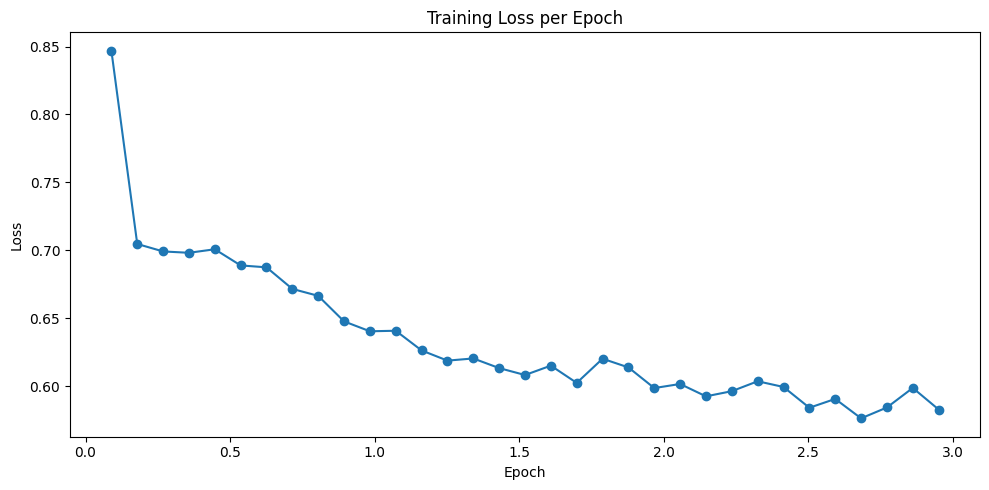

In [29]:
# Evaluate the model
results = trainer.evaluate()
print(results)

import matplotlib.pyplot as plt

# Unpack the epoch and values
train_epochs, train_losses = zip(*logger_callback.train_loss)
eval_epochs, eval_accuracies = zip(*logger_callback.eval_accuracy)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

In [ ]:
from transformer.BERT import BertPrediction

model = BertPrediction(version="0.2")
model.predict("I didn't like the service especially the food. I hate it so much")


Device set to use cuda:0


[{'label': 1, 'score': 0.7482501864433289}]